# WikiSpeedAI Analysis - Network Metrics

This notebook analyzes JSON files generated by wikispeedai and calculates network metrics to compare Wikipedia vs LLM exploration.

In [13]:
import json
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from pathlib import Path
from collections import defaultdict, Counter
import warnings

warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

def load_json_files(directory_pattern='**'):
    """
    Load all JSON files from directories matching the pattern.
    Args:
        directory_pattern: Pattern for directory names (default: '**' = all recursively)
    Returns:
        List of dictionaries containing data from JSON files
    """
    data_list = []
    
    # Search for all JSON files in directories matching the pattern (recursively)
    json_pattern = f"{directory_pattern}/*.json"
    json_files = glob.glob(json_pattern, recursive=True)
    
    print(f"Searching for JSON files with pattern: {json_pattern}")
    print(f"Files found: {len(json_files)}")
    
    for json_file in json_files:
        try:
            with open(json_file, 'r', encoding='utf-8') as f:
                data = json.load(f)
                # Add file information
                data['_file_path'] = json_file
                data['_file_name'] = os.path.basename(json_file)
                data['_directory'] = os.path.dirname(json_file)
                data_list.append(data)
        except Exception as e:
            print(f"Error loading {json_file}: {e}")
    
    print(f"Successfully loaded {len(data_list)} JSON files\n")
    return data_list

# Load all JSON files from directories
all_data = load_json_files()


Searching for JSON files with pattern: **/*.json
Files found: 156
Error loading openai_gpt-oss-20b-1\all_results_run1.json: list indices must be integers or slices, not str
Successfully loaded 155 JSON files



## Load Wikipedia Links

Load the Wikipedia hyperlinks structure from the pickle file created by `wiki_links.py`.

In [15]:
import pickle

# Load Wikipedia links from pickle file
wikipedia_links_file = 'wikipedia_links.pkl'

try:
    with open(wikipedia_links_file, 'rb') as f:
        wikipedia_links = pickle.load(f)
    
    print(f"Loaded Wikipedia links for {len(wikipedia_links)} pages")
    print(f"Total links: {sum(len(links) for links in wikipedia_links.values())}")
    print(f"Average links per page: {sum(len(links) for links in wikipedia_links.values()) / len(wikipedia_links):.1f}")
    
except FileNotFoundError:
    print(f"File '{wikipedia_links_file}' not found!")
    print("Please run 'python wiki_links.py' first to download Wikipedia links.")
    wikipedia_links = None

Loaded Wikipedia links for 18 pages
Total links: 14179
Average links per page: 787.7


## Build Wikipedia Graph

Build a graph using the actual Wikipedia hyperlink structure.

In [17]:
def build_wikipedia_graph(wikipedia_links):
    """
    Build a directed graph from Wikipedia hyperlink structure.
    Args:
        wikipedia_links: Dictionary mapping page titles to lists of linked pages
    Returns:
        networkx.DiGraph: Directed graph with Wikipedia links
    """
    G = nx.DiGraph()
    
    if wikipedia_links is None:
        return G
    
    for source_page, target_pages in wikipedia_links.items():
        # Add source node
        if source_page not in G.nodes():
            G.add_node(source_page, page=source_page, source='wikipedia')
        
        # Add edges to all linked pages
        for target_page in target_pages:
            # Only add edges to pages that are also in our dataset
            if target_page in wikipedia_links:
                if target_page not in G.nodes():
                    G.add_node(target_page, page=target_page, source='wikipedia')
                
                # Add edge
                G.add_edge(source_page, target_page, weight=1, source='wikipedia')
    
    return G

# Build Wikipedia graph
G_wiki = build_wikipedia_graph(wikipedia_links)

print(f"Wikipedia Graph Statistics:")
print(f"  - Number of nodes (pages): {G_wiki.number_of_nodes()}")
print(f"  - Number of edges (links): {G_wiki.number_of_edges()}")
print(f"  - Graph is connected: {nx.is_weakly_connected(G_wiki) if G_wiki.number_of_nodes() > 0 else 'N/A'}")

if G_wiki.number_of_nodes() > 0:
    print(f"  - Average degree: {np.mean([d for n, d in G_wiki.degree()]):.2f}")
    print(f"  - Density: {nx.density(G_wiki):.4f}")

Wikipedia Graph Statistics:
  - Number of nodes (pages): 18
  - Number of edges (links): 86
  - Graph is connected: True
  - Average degree: 9.56
  - Density: 0.2810


## Compare LLM vs Wikipedia Metrics

Calculate and compare network metrics between LLM navigation and actual Wikipedia structure.

In [18]:
def calculate_all_metrics(G, graph_name="Graph"):
    """Calculate all network metrics for a graph."""
    metrics = {}
    
    if G.number_of_nodes() == 0:
        print(f"{graph_name}: Empty graph")
        return metrics
    
    # Basic metrics
    metrics['num_nodes'] = G.number_of_nodes()
    metrics['num_edges'] = G.number_of_edges()
    metrics['density'] = nx.density(G)
    metrics['avg_degree'] = np.mean([d for n, d in G.degree()])
    
    # Degree distribution
    in_degrees = [d for n, d in G.in_degree()]
    out_degrees = [d for n, d in G.out_degree()]
    metrics['avg_in_degree'] = np.mean(in_degrees) if in_degrees else 0
    metrics['avg_out_degree'] = np.mean(out_degrees) if out_degrees else 0
    metrics['max_in_degree'] = max(in_degrees) if in_degrees else 0
    metrics['max_out_degree'] = max(out_degrees) if out_degrees else 0
    
    # Clustering coefficient
    G_undirected = G.to_undirected()
    clustering_coeffs = nx.clustering(G_undirected)
    metrics['avg_clustering'] = np.mean(list(clustering_coeffs.values()))
    
    # Average shortest path (if connected)
    if nx.is_weakly_connected(G):
        try:
            metrics['avg_shortest_path'] = nx.average_shortest_path_length(G_undirected)
        except:
            metrics['avg_shortest_path'] = None
    else:
        # Calculate for largest component
        components = list(nx.weakly_connected_components(G))
        if components:
            largest_comp = max(components, key=len)
            subgraph = G.subgraph(largest_comp).to_undirected()
            try:
                metrics['avg_shortest_path'] = nx.average_shortest_path_length(subgraph)
            except:
                metrics['avg_shortest_path'] = None
        else:
            metrics['avg_shortest_path'] = None
    
    return metrics

# Calculate metrics for both graphs
print("=" * 60)
print("CALCULATING METRICS FOR LLM GRAPH")
print("=" * 60)
llm_metrics = calculate_all_metrics(G_llm, "LLM")

print("\n" + "=" * 60)
print("CALCULATING METRICS FOR WIKIPEDIA GRAPH")
print("=" * 60)
wiki_metrics = calculate_all_metrics(G_wiki, "Wikipedia")

# Create comparison DataFrame
if llm_metrics and wiki_metrics:
    comparison_df = pd.DataFrame({
        'Metric': [
            'Number of Nodes',
            'Number of Edges',
            'Density',
            'Average Degree',
            'Average In-Degree',
            'Average Out-Degree',
            'Max In-Degree',
            'Max Out-Degree',
            'Average Clustering',
            'Average Shortest Path'
        ],
        'LLM': [
            llm_metrics.get('num_nodes', 'N/A'),
            llm_metrics.get('num_edges', 'N/A'),
            f"{llm_metrics.get('density', 0):.6f}",
            f"{llm_metrics.get('avg_degree', 0):.2f}",
            f"{llm_metrics.get('avg_in_degree', 0):.2f}",
            f"{llm_metrics.get('avg_out_degree', 0):.2f}",
            llm_metrics.get('max_in_degree', 'N/A'),
            llm_metrics.get('max_out_degree', 'N/A'),
            f"{llm_metrics.get('avg_clustering', 0):.4f}",
            f"{llm_metrics.get('avg_shortest_path', 0):.4f}" if llm_metrics.get('avg_shortest_path') else 'N/A'
        ],
        'Wikipedia': [
            wiki_metrics.get('num_nodes', 'N/A'),
            wiki_metrics.get('num_edges', 'N/A'),
            f"{wiki_metrics.get('density', 0):.6f}",
            f"{wiki_metrics.get('avg_degree', 0):.2f}",
            f"{wiki_metrics.get('avg_in_degree', 0):.2f}",
            f"{wiki_metrics.get('avg_out_degree', 0):.2f}",
            wiki_metrics.get('max_in_degree', 'N/A'),
            wiki_metrics.get('max_out_degree', 'N/A'),
            f"{wiki_metrics.get('avg_clustering', 0):.4f}",
            f"{wiki_metrics.get('avg_shortest_path', 0):.4f}" if wiki_metrics.get('avg_shortest_path') else 'N/A'
        ]
    })
    
    print("\n" + "=" * 60)
    print("COMPARISON: LLM vs WIKIPEDIA")
    print("=" * 60)
    print(comparison_df.to_string(index=False))
    
    # Save comparison
    comparison_df.to_csv('llm_vs_wikipedia_comparison.csv', index=False)
    print("\nComparison saved to: llm_vs_wikipedia_comparison.csv")
else:
    print("\nCannot create comparison - missing data")

CALCULATING METRICS FOR LLM GRAPH

CALCULATING METRICS FOR WIKIPEDIA GRAPH

COMPARISON: LLM vs WIKIPEDIA
               Metric      LLM Wikipedia
      Number of Nodes       46        18
      Number of Edges       59        86
              Density 0.028502  0.281046
       Average Degree     2.57      9.56
    Average In-Degree     1.28      4.78
   Average Out-Degree     1.28      4.78
        Max In-Degree        7        10
       Max Out-Degree       10         9
   Average Clustering   0.1093    0.5566
Average Shortest Path   4.4415    1.8431

Comparison saved to: llm_vs_wikipedia_comparison.csv


### Build a directed graph from a list of navigation data

In [19]:
def build_graph_from_data(data_list, source_type='llm'):
    """
    Build a directed graph from a list of navigation data.
    Args:
        data_list: List of dictionaries with navigation results
        source_type: Source type ('llm', 'wikipedia', etc.')
    Returns:
        networkx.DiGraph: Directed graph with paths
    """
    G = nx.DiGraph()
    
    for data in data_list:
        path = data.get('path', [])
        
        # Add nodes and edges from the path
        for i in range(len(path) - 1):
            source = path[i]
            target = path[i + 1]
            
            # Add nodes with attributes
            if source not in G.nodes():
                G.add_node(source, page=source, source=source_type)
            if target not in G.nodes():
                G.add_node(target, page=target, source=source_type)
            
            # Add edge (or increment weight if it already exists)
            if G.has_edge(source, target):
                G[source][target]['weight'] += 1
            else:
                G.add_edge(source, target, weight=1, source=source_type)
    
    return G

# Build the graph from all data
G_llm = build_graph_from_data(all_data, source_type='llm')

print(f"LLM Graph Statistics:")
print(f"  - Number of nodes (pages): {G_llm.number_of_nodes()}")
print(f"  - Number of edges (links): {G_llm.number_of_edges()}")
print(f"  - Graph is connected: {nx.is_weakly_connected(G_llm)}")

if G_llm.number_of_nodes() > 0:
    print(f"  - Average degree: {np.mean([d for n, d in G_llm.degree()]):.2f}")
    print(f"  - Density: {nx.density(G_llm):.4f}")

LLM Graph Statistics:
  - Number of nodes (pages): 46
  - Number of edges (links): 59
  - Graph is connected: True
  - Average degree: 2.57
  - Density: 0.0285


###  Calculate the average shortest path length of the graph

In [20]:
def calculate_average_shortest_path(G):
    """
    Calculate the average shortest path length of the graph.
    If the graph is not connected, calculate for each connected component.
    """
    if G.number_of_nodes() == 0:
        return None
    
    # For directed graphs, use weakly connected components
    if nx.is_weakly_connected(G):
        try:
            # Convert to undirected graph for calculation
            G_undirected = G.to_undirected()
            avg_path = nx.average_shortest_path_length(G_undirected)
            return avg_path
        except:
            return None
    else:
        # Calculate for each weakly connected component
        components = list(nx.weakly_connected_components(G))
        path_lengths = []
        
        for comp in components:
            if len(comp) > 1:
                subgraph = G.subgraph(comp).to_undirected()
                try:
                    avg_path = nx.average_shortest_path_length(subgraph)
                    path_lengths.append(avg_path)
                except:
                    pass
        
        if path_lengths:
            return np.mean(path_lengths)
        return None

# Calculate average shortest path length
avg_shortest_path = calculate_average_shortest_path(G_llm)

print("Average Shortest Path Length:")
if avg_shortest_path is not None:
    print(f"  - LLM Exploration: {avg_shortest_path:.4f}")
else:
    print("  - Not calculable (disconnected graph or too small)")

Average Shortest Path Length:
  - LLM Exploration: 4.4415


### Calculate the average clustering coefficient and distribution

In [21]:
def calculate_clustering_metrics(G):
    """
    Calculate the average clustering coefficient and distribution.
    """
    if G.number_of_nodes() == 0:
        return None, None
    
    # Convert to undirected graph for clustering coefficient
    G_undirected = G.to_undirected()
    
    # Calculate clustering coefficient for each node
    clustering_coeffs = nx.clustering(G_undirected)
    
    # Average
    avg_clustering = np.mean(list(clustering_coeffs.values()))
    
    return avg_clustering, clustering_coeffs

# Calculate clustering coefficient
avg_clustering, clustering_dict = calculate_clustering_metrics(G_llm)

print("Local Clustering Coefficient:")
if avg_clustering is not None:
    print(f"  - Average clustering coefficient: {avg_clustering:.4f}")
    print(f"  - Min clustering: {min(clustering_dict.values()):.4f}")
    print(f"  - Max clustering: {max(clustering_dict.values()):.4f}")
    print(f"  - Median clustering: {np.median(list(clustering_dict.values())):.4f}")
    
    # Show nodes with highest clustering
    top_clustered = sorted(clustering_dict.items(), key=lambda x: x[1], reverse=True)[:10]
    print("\n  Top 10 nodes with highest clustering:")
    for node, coeff in top_clustered:
        print(f"    - {node}: {coeff:.4f}")
else:
    print("  - Not calculable")

Local Clustering Coefficient:
  - Average clustering coefficient: 0.1093
  - Min clustering: 0.0000
  - Max clustering: 1.0000
  - Median clustering: 0.0000

  Top 10 nodes with highest clustering:
    - Europe: 1.0000
    - University of Zurich: 1.0000
    - Nobel Prize in Physics: 1.0000
    - Computer science (disambiguation): 0.5000
    - Computer science education: 0.3333
    - New York City: 0.3333
    - Switzerland: 0.2000
    - Zurich: 0.1667
    - History of computing: 0.1667
    - Sweden: 0.1000


### Calculate metrics related to edges and graph density

In [22]:
def calculate_graph_density_metrics(G):
    """
    Calculate metrics related to edges and graph density.
    """
    if G.number_of_nodes() == 0:
        return {}
    
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    density = nx.density(G)
    
    # Calculate the maximum possible number of edges for a directed graph
    max_possible_edges = num_nodes * (num_nodes - 1)
    
    # Degree distribution (in-degree and out-degree)
    in_degrees = [d for n, d in G.in_degree()]
    out_degrees = [d for n, d in G.out_degree()]
    
    metrics = {
        'num_nodes': num_nodes,
        'num_edges': num_edges,
        'density': density,
        'max_possible_edges': max_possible_edges,
        'avg_in_degree': np.mean(in_degrees) if in_degrees else 0,
        'avg_out_degree': np.mean(out_degrees) if out_degrees else 0,
        'max_in_degree': max(in_degrees) if in_degrees else 0,
        'max_out_degree': max(out_degrees) if out_degrees else 0,
    }
    
    return metrics

# Calculate density metrics
density_metrics = calculate_graph_density_metrics(G_llm)

print("Edge and Density Metrics:")
print(f"  - Number of nodes: {density_metrics['num_nodes']}")
print(f"  - Number of edges: {density_metrics['num_edges']}")
print(f"  - Graph density: {density_metrics['density']:.6f}")
print(f"  - Max possible edges: {density_metrics['max_possible_edges']}")
print(f"\n  - Average in-degree: {density_metrics['avg_in_degree']:.2f}")
print(f"  - Average out-degree: {density_metrics['avg_out_degree']:.2f}")
print(f"  - Max in-degree: {density_metrics['max_in_degree']}")
print(f"  - Max out-degree: {density_metrics['max_out_degree']}")

Edge and Density Metrics:
  - Number of nodes: 46
  - Number of edges: 59
  - Graph density: 0.028502
  - Max possible edges: 2070

  - Average in-degree: 1.28
  - Average out-degree: 1.28
  - Max in-degree: 7
  - Max out-degree: 10


### Calculate PageRank for all nodes in the graph

In [23]:
def calculate_pagerank(G, alpha=0.85, num_walks=10000, walk_length=100):
    """
    Calculate PageRank using random walker simulation (Monte Carlo method).
    Args:
        G: NetworkX graph
        alpha: Probability of following a link (vs random jump, default 0.85)
        num_walks: Number of random walks to simulate (default 10000)
        walk_length: Length of each random walk (default 100)
    Returns:
        dict: PageRank for each node (normalized visit counts)
    """
    if G.number_of_nodes() == 0:
        return {}
    
    import random
    
    visit_counts = {node: 0 for node in G.nodes()}
    nodes_list = list(G.nodes())
    
    for _ in range(num_walks):
        current_node = random.choice(nodes_list)
        
        for _ in range(walk_length):
            visit_counts[current_node] += 1

            if random.random() > alpha:
                current_node = random.choice(nodes_list)
            else:
                out_edges = list(G.successors(current_node))
                if out_edges:
                    current_node = random.choice(out_edges)
                else:
                    current_node = random.choice(nodes_list)

    total_visits = sum(visit_counts.values())
    pagerank = {node: count / total_visits for node, count in visit_counts.items()}
    
    return pagerank

pagerank_scores = calculate_pagerank(G_llm)

print("PageRank Distribution (Random Walker Method):")
if pagerank_scores:
    pr_values = list(pagerank_scores.values())
    print(f"  - Mean PageRank: {np.mean(pr_values):.6f}")
    print(f"  - Median PageRank: {np.median(pr_values):.6f}")
    print(f"  - Standard deviation: {np.std(pr_values):.6f}")
    print(f"  - Min PageRank: {min(pr_values):.6f}")
    print(f"  - Max PageRank: {max(pr_values):.6f}")
    
    top_pages = sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)[:10]
    print("\n  Top 10 pages by PageRank:")
    for i, (page, score) in enumerate(top_pages, 1):
        print(f"    {i}. {page}: {score:.6f}")
else:
    print("  - Not calculable")

PageRank Distribution (Random Walker Method):
  - Mean PageRank: 0.021739
  - Median PageRank: 0.014596
  - Standard deviation: 0.022747
  - Min PageRank: 0.009916
  - Max PageRank: 0.148016

  Top 10 pages by PageRank:
    1. Stockholm: 0.148016
    2. Sweden: 0.087434
    3. European Union: 0.040593
    4. Greece: 0.036363
    5. Abbasid Caliphate: 0.032074
    6. Mediterranean Sea: 0.031287
    7. Switzerland: 0.030974
    8. House of Wisdom: 0.026223
    9. Aegean Sea: 0.025304
    10. Germany: 0.025129


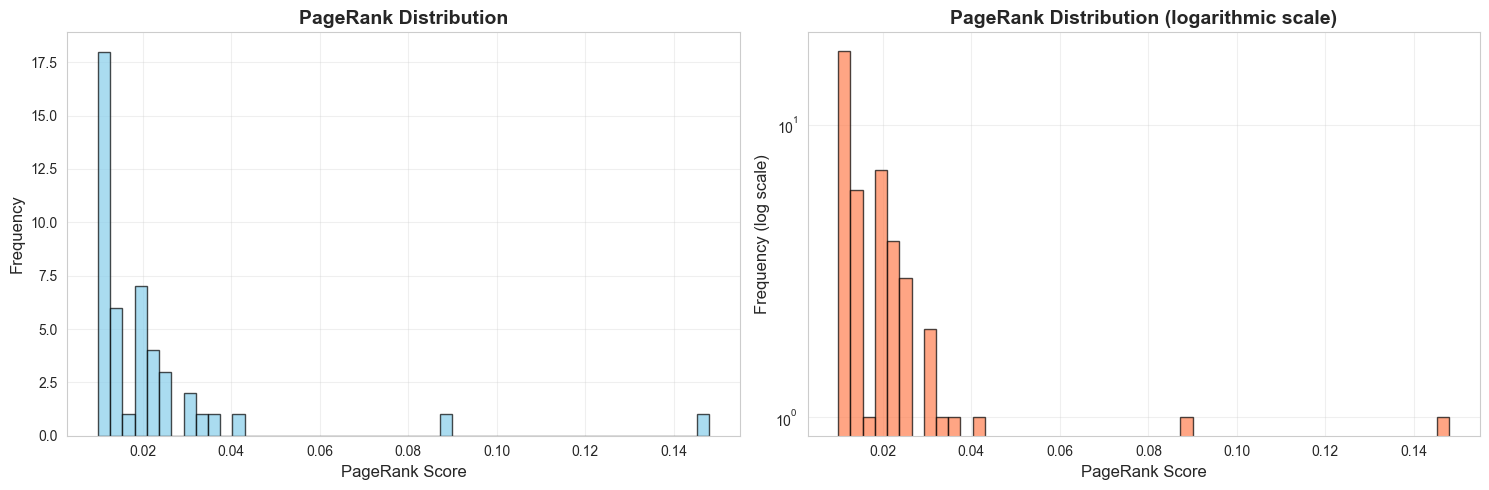

PageRank distribution plots generated


In [24]:
if pagerank_scores:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Histogram of PageRank distribution
    pr_values = list(pagerank_scores.values())
    axes[0].hist(pr_values, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
    axes[0].set_xlabel('PageRank Score', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].set_title('PageRank Distribution', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    # Log-scale histogram to better see the tail
    axes[1].hist(pr_values, bins=50, edgecolor='black', alpha=0.7, color='coral')
    axes[1].set_xlabel('PageRank Score', fontsize=12)
    axes[1].set_ylabel('Frequency (log scale)', fontsize=12)
    axes[1].set_title('PageRank Distribution (logarithmic scale)', fontsize=14, fontweight='bold')
    axes[1].set_yscale('log')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"PageRank distribution plots generated")
else:
    print("No PageRank data available for visualization")

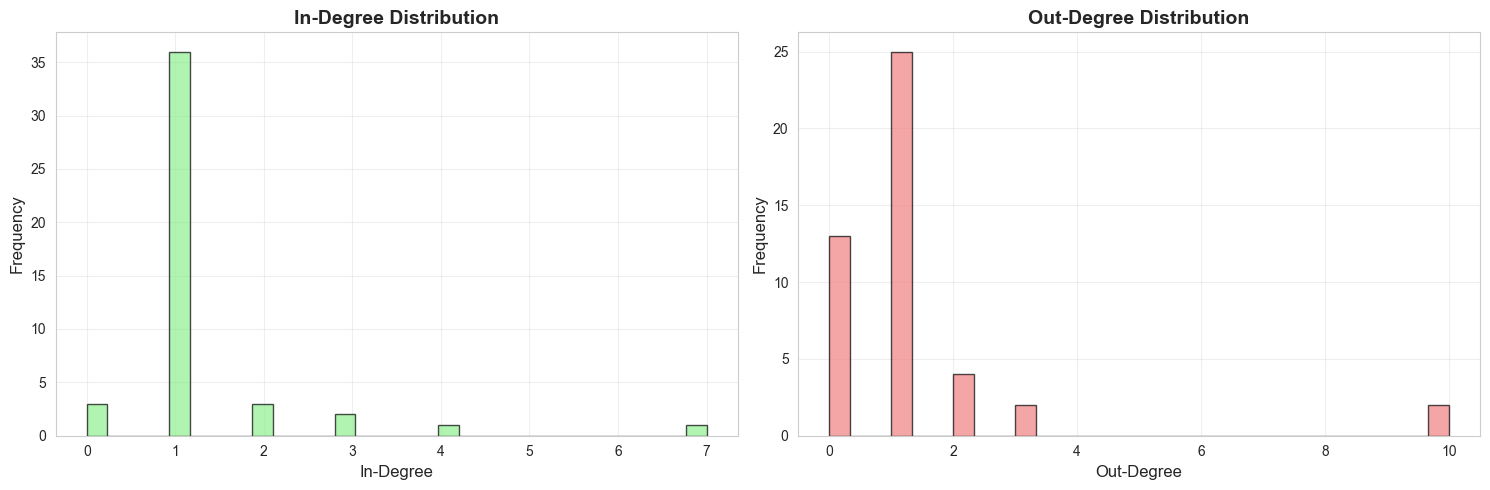

Degree distribution plots generated


In [25]:
if G_llm.number_of_nodes() > 0:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # In-degree distribution
    in_degrees = [d for n, d in G_llm.in_degree()]
    axes[0].hist(in_degrees, bins=30, edgecolor='black', alpha=0.7, color='lightgreen')
    axes[0].set_xlabel('In-Degree', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].set_title('In-Degree Distribution', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    # Out-degree distribution
    out_degrees = [d for n, d in G_llm.out_degree()]
    axes[1].hist(out_degrees, bins=30, edgecolor='black', alpha=0.7, color='lightcoral')
    axes[1].set_xlabel('Out-Degree', fontsize=12)
    axes[1].set_ylabel('Frequency', fontsize=12)
    axes[1].set_title('Out-Degree Distribution', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Degree distribution plots generated")
else:
    print("Empty graph")

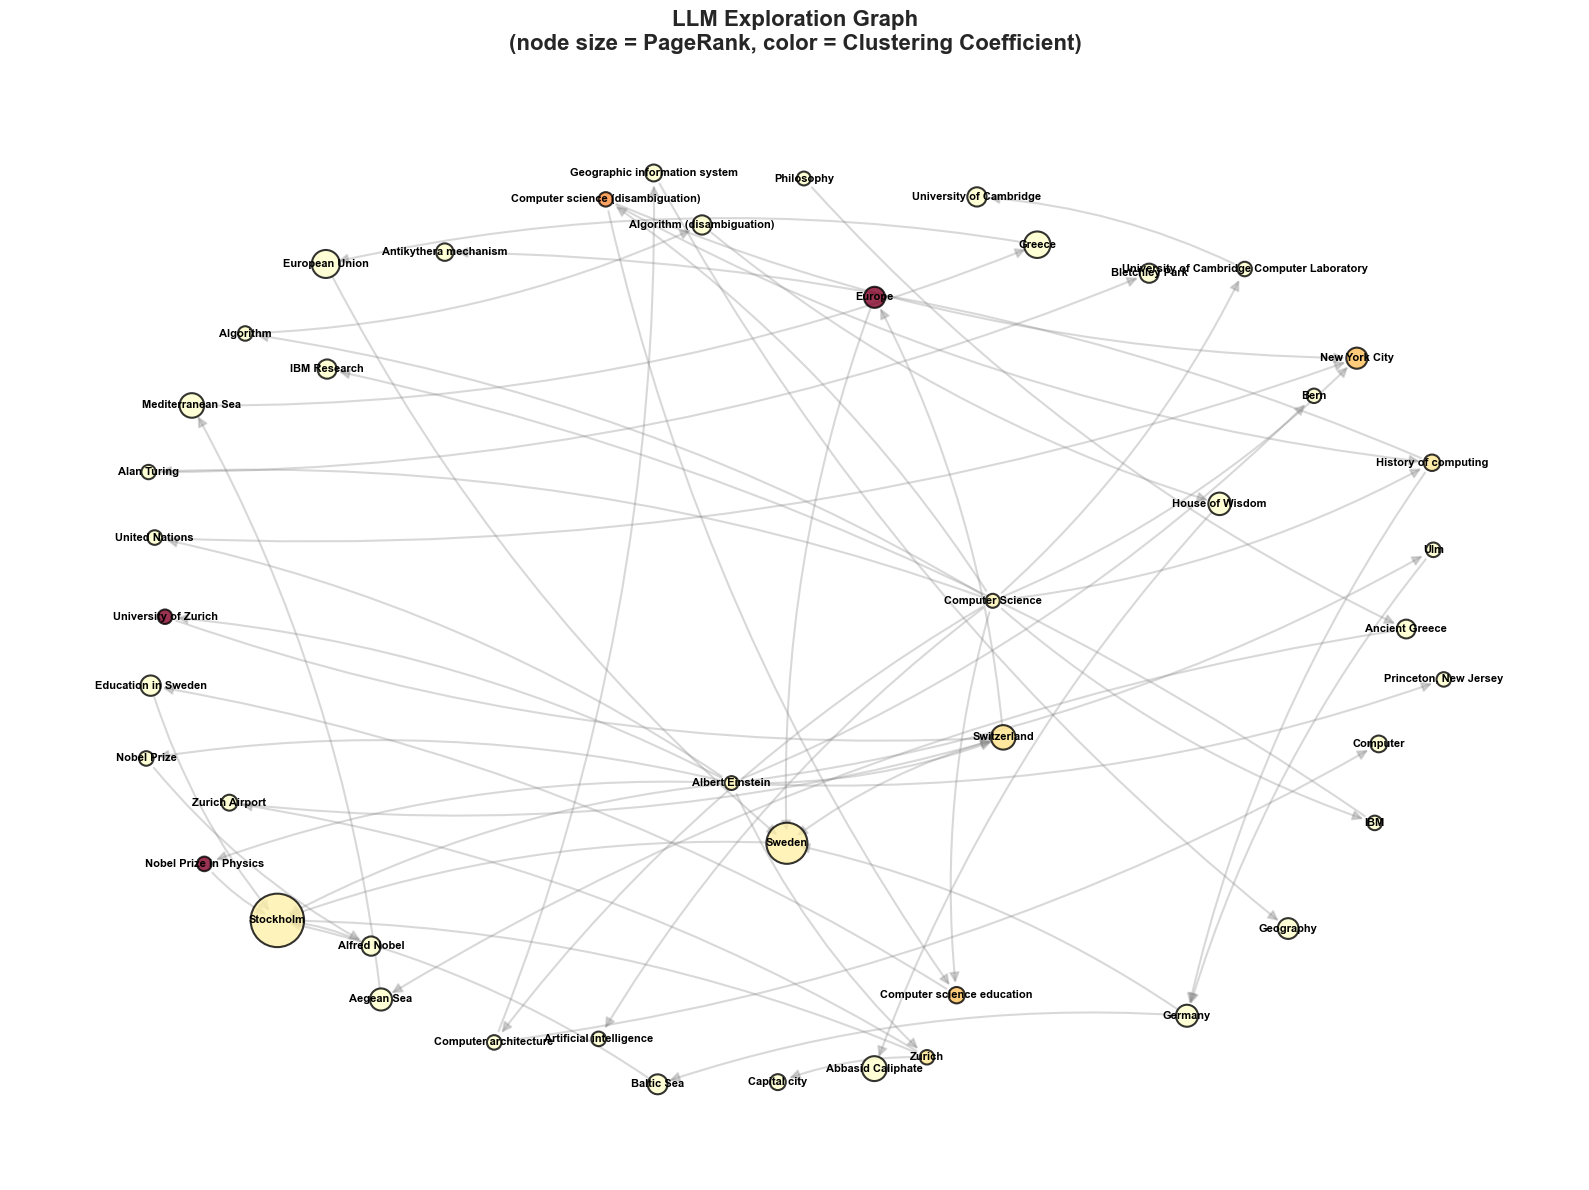

Graph visualized (46 nodes)


In [26]:
if G_llm.number_of_nodes() > 0 and G_llm.number_of_nodes() < 100:
    # Visualize only if the graph is not too large
    plt.figure(figsize=(16, 12))
    
    # Use spring layout to position nodes
    pos = nx.spring_layout(G_llm, k=2, iterations=50, seed=42)
    
    # Node size based on PageRank
    if pagerank_scores:
        node_sizes = [pagerank_scores.get(node, 0) * 10000 for node in G_llm.nodes()]
    else:
        node_sizes = [100 for _ in G_llm.nodes()]
    
    # Node color based on clustering coefficient
    if clustering_dict:
        node_colors = [clustering_dict.get(node, 0) for node in G_llm.nodes()]
    else:
        node_colors = ['skyblue' for _ in G_llm.nodes()]
    
    # Draw the graph
    nx.draw_networkx_nodes(G_llm, pos, node_size=node_sizes, 
                          node_color=node_colors, cmap='YlOrRd',
                          alpha=0.8, edgecolors='black', linewidths=1.5)
    
    nx.draw_networkx_edges(G_llm, pos, alpha=0.3, edge_color='gray',
                          arrows=True, arrowsize=15, width=1.5,
                          connectionstyle='arc3,rad=0.1')
    
    nx.draw_networkx_labels(G_llm, pos, font_size=8, font_weight='bold')
    
    plt.title('LLM Exploration Graph\n(node size = PageRank, color = Clustering Coefficient)', 
              fontsize=16, fontweight='bold', pad=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    print(f"Graph visualized ({G_llm.number_of_nodes()} nodes)")
elif G_llm.number_of_nodes() >= 100:
    print(f"Graph too large for visualization ({G_llm.number_of_nodes()} nodes)")
    print("   Consider filtering or aggregating the data for better visualization")
else:
    print("Empty graph")

In [27]:
# Create a DataFrame with all metrics
metrics_summary = {
    'Metric': [
        'Number of Nodes (Pages)',
        'Number of Edges (Links)',
        'Graph Density',
        'Average Shortest Path Length',
        'Average Clustering Coefficient',
        'Average In-Degree',
        'Average Out-Degree',
        'Mean PageRank',
        'Median PageRank',
        'Max PageRank'
    ],
    'Value': [
        density_metrics['num_nodes'],
        density_metrics['num_edges'],
        f"{density_metrics['density']:.6f}",
        f"{avg_shortest_path:.4f}" if avg_shortest_path else "N/A",
        f"{avg_clustering:.4f}" if avg_clustering else "N/A",
        f"{density_metrics['avg_in_degree']:.2f}",
        f"{density_metrics['avg_out_degree']:.2f}",
        f"{np.mean(list(pagerank_scores.values())):.6f}" if pagerank_scores else "N/A",
        f"{np.median(list(pagerank_scores.values())):.6f}" if pagerank_scores else "N/A",
        f"{max(pagerank_scores.values()):.6f}" if pagerank_scores else "N/A"
    ]
}

df_metrics = pd.DataFrame(metrics_summary)

print("NETWORK METRICS SUMMARY - LLM EXPLORATION")
print(df_metrics.to_string(index=False))

NETWORK METRICS SUMMARY - LLM EXPLORATION
                        Metric    Value
       Number of Nodes (Pages)       46
       Number of Edges (Links)       59
                 Graph Density 0.028502
  Average Shortest Path Length   4.4415
Average Clustering Coefficient   0.1093
             Average In-Degree     1.28
            Average Out-Degree     1.28
                 Mean PageRank 0.021739
               Median PageRank 0.014596
                  Max PageRank 0.148016


In [28]:
# Save metrics to a CSV file
output_file = 'network_metrics_summary.csv'
df_metrics.to_csv(output_file, index=False)
print(f"Metrics saved to: {output_file}")

# Save PageRank scores
if pagerank_scores:
    df_pagerank = pd.DataFrame(list(pagerank_scores.items()), 
                               columns=['Page', 'PageRank'])
    df_pagerank = df_pagerank.sort_values('PageRank', ascending=False)
    pagerank_file = 'pagerank_scores.csv'
    df_pagerank.to_csv(pagerank_file, index=False)
    print(f"PageRank scores saved to: {pagerank_file}")

# Save clustering coefficients
if clustering_dict:
    df_clustering = pd.DataFrame(list(clustering_dict.items()),
                                 columns=['Page', 'Clustering_Coefficient'])
    df_clustering = df_clustering.sort_values('Clustering_Coefficient', ascending=False)
    clustering_file = 'clustering_coefficients.csv'
    df_clustering.to_csv(clustering_file, index=False)
    print(f"Clustering coefficients saved to: {clustering_file}")

print("\nAnalysis completed!")

Metrics saved to: network_metrics_summary.csv
PageRank scores saved to: pagerank_scores.csv
Clustering coefficients saved to: clustering_coefficients.csv

Analysis completed!
